# Intro

`CausalImpact` package created by Google estimates the impact of an intervention on a time series. In this tutorial, we will talk about how to tune the hyperparameters of the time series causal impact model using the python package `CausalImpact`.

Let's get started!

# Step 1: Install and Import Libraries

In step 1, we will install and import the python libraries.

Firstly, let's install `pycausalimpact` for time series causal analysis.

In [16]:
# Install python version of causal impact
!pip install pycausalimpact

After the installation is completed, we can import the libraries.
* `pandas`, `numpy`, and `datetime` are imported for data processing.
* `ArmaProcess` is imported for synthetic time series data creation.
* `matplotlib` and `seaborn` are for visualization.
* `CausalImpact` is for time series treatment effects estimation.

In [17]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

# Step 2：Create Dataset

In step 2, we will create a synthetic time-series dataset for the causal impact analysis. The ground truth of the causal impact is usually not available. The benefit of using a synthetic dataset is that we can validate the accuracy of the model results.

The `CausalImpact` package requires two types of time series:
* A response time series that is directly affected by the intervention.
* And one or more control time series that are not impacted by the intervention.

The idea is to build a time series model to predict the counterfactual outcome. In other words, the model will use the control time series to predict what the response time series outcome would have been if there had been no intervention.

In this example, we created one response time series variable and two control time series variables.
* To make the dataset reproducible, a random seed is set at the beginning of the code.
* Then an autoregressive moving average (ARMA) process is created.
 * For the first control time series variable `X1`, the autoregressive (AR) part has two coefficients 0.95 and 0.04, and the moving average (MA) part has two coefficients 0.6 and 0.3. A constant value of 10 is added to the autoregressive moving average (ARMA) process.
 * For the second control time series variable `X2`, the autoregressive (AR) part has two coefficients 0.85 and 0.01, and the moving average (MA) part has two coefficients 0.7 and 0.2. A constant value of 20 is added to the autoregressive moving average (ARMA) process.
* After setting the autoregressive moving average (ARMA) coefficients, 5000 samples are generated for `X1` and `X2`.
* The response time series variable `y` is a function of the control time series variables. It equals 10 times `X1` plus 2 times `X2`, then plus a random value.
* The intervention happens at the index of 3000, and the true causal impact is 20.


In [18]:
# Set up a seed for reproducibility
np.random.seed(42)

# Autoregressive coefficients
arparams1 = np.array([.95, .04])
arparams2 = np.array([.85, .01])

# Moving average coefficients
maparams1 = np.array([.6, .3])
maparams2 = np.array([.7, .2])

# Create an ARMA process
arma_process1 = ArmaProcess.from_coeffs(arparams1, maparams1)
arma_process2 = ArmaProcess.from_coeffs(arparams2, maparams2)

# Create the control time-series
X1 = 10 + arma_process1.generate_sample(nsample=5000)
X2 = 20 + arma_process2.generate_sample(nsample=5000)

# Create the response time-series
y = 10 * X1 + 2 * X2 + np.random.normal(size=5000)

# Add the true causal impact
y[3000:] += 20

A time series usually has a time variable indicating the frequency of the data collected. We created 5000 dates beginning on January 1st, 2000 using the pandas `date_range` function. freq='D' indicates the dataset has daily data.

After that, a pandas dataframe is created with the control variable `X1`, `X2`, the response varialbe `y`, and the index `dates`.  

In [19]:
# Create dates
dates = pd.date_range('2000-01-01', freq='D', periods=5000)

# Create dataframe
df = pd.DataFrame({'dates': dates, 'y': y, 'X1': X1, 'X2': X2}, columns=['dates', 'y', 'X1', 'X2'])

# Set dates as index
df.set_index('dates', inplace=True)

# Take a look at the data
df.head()

,y,X1,X2
dates,,,
2000-01-01,143.441127,10.496714,19.576240
2000-01-02,143.790444,10.631643,18.889758
2000-01-03,146.447896,11.333673,16.854272
2000-01-04,163.009219,13.162419,15.637306
2000-01-05,173.319119,13.931616,16.402890


# Step 3: Set Pre and Post Periods

In step 3, we will set the pre and the post intervention periods.

We can see that The time-series start date is `2000-01-01`, the time-series end date is `2013-09-08`, and the treatment start date is `2008-03-19`.

In [20]:
# Print out the time series start date
print(f'The time-series start date is :{df.index.min()}')

# Print out the time series end date
print(f'The time-series end date is :{df.index.max()}')

# Print out the intervention start date
print(f'The treatment start date is :{df.index[3000]}')

The time-series start date is :2000-01-01 00:00:00
The time-series end date is :2013-09-08 00:00:00
The treatment start date is :2008-03-19 00:00:00


Next, let's visualize the time-series data.

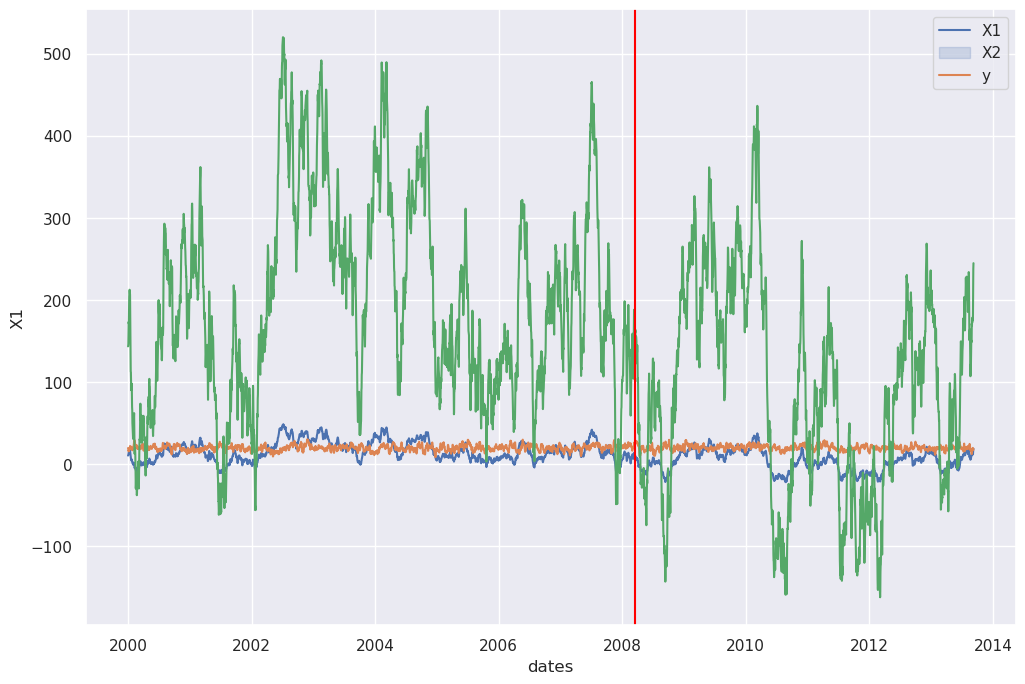

In [21]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df.index, y=df['X1'])
sns.lineplot(x=df.index, y=df['X2'])
sns.lineplot(x=df.index, y=df['y'])
plt.axvline(x= df.index[3000], color='red')
plt.legend(labels = ['X1', 'X2', 'y'])

In the chart, the blue line is the first control time series, the orange line is the second control time series, and the green line is the response time series.

The python `CausalImpact` package requires the pre and the post intervention periods to be specified.

In our dataset, the intervention starts on the 3001st day, so the pre-intervention time period includes the first 3000 days, and the post-intervention time period includes the last 2000 days. That corresponds to the start date of `2000-01-01` and end date of `2008-03-18` for the pre-period, and the start date of `2008-03-19` and end date of `2013-09-08` for the post-period.

In [22]:
# Set pre-period
pre_period = [str(df.index.min())[:10], str(df.index[2999])[:10]]

# Set post-period
post_period = [str(df.index[3000])[:10], str(df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2000-01-01', '2008-03-18']
The post-period is ['2008-03-19', '2013-09-08']


# Step 4: Causal Impact on Time Series with Default Hyperparameters

In step 4, we will execute the causal impact analysis on the time series with Default Hyperparameters.

The causality analysis has two assumptions:
* Assumption 1: There are one or more control time series that are highly correlated with the response variable, but not impacted by the intervention. Violation of this assumption can result in wrong conclusions about the existence, the direction, or the magnitude of the treatment effect.
* Assumption 2: The correlation between the control and the response time series is the same for pre and post intervention.

The synthetic time series data we created satisfy the two assumptions.

The python `CausalImpact` package has a function called `CausalImpact` that implements a Bayesian Structural Time Series Model (BSTS) on the backend. It has three required inputs:
* `data` takes the python dataframe name.
* `pre_period` takes the starting and the ending index values for the pre-intervention period.
* `post_period` takes the starting and the ending index values for the post-intervention period.

After saving the output object in a variable called `impact_default`, we can run `impact_default.summary()` to get the results summary.

In [23]:
# Causal impact model
impact_default = CausalImpact(data=df, pre_period=pre_period, post_period=post_period)

# Causal impact summary
print(impact_default.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.93 (25.33)      141867.54 (50652.72)
95% CI                    [20.77, 120.05]    [41538.2, 240093.22]

Absolute effect (s.d.)    20.64 (25.33)      41287.23 (50652.72)
95% CI                    [-28.47, 70.81]    [-56938.45, 141616.58]

Relative effect (s.d.)    29.1% (35.7%)      29.1% (35.7%)
95% CI                    [-40.13%, 99.82%]  [-40.13%, 99.82%]

Posterior tail-area probability p: 0.2
Posterior prob. of a causal effect: 80.32%

For more details run the command: print(impact.summary('report'))


The summary results tell us that:
* The absolute causal effect is 20.64, which is close to the true causal impact of 20.
* The 95% confidence interval for the absolute causal effect is -28.47 to 70.81.

To learn more about the `CausalImpact` function, please check out my tutorial [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc).

# Step 5: Hyperparameter Tuning for niter

In step 5, we will talk about how to tune the hyperparameter `niter` for `CausalImpact`.

`niter` is the number of MCMC samples. Bayesian inference usually needs at least 1000 samples to get reasonable results. The default value for `niter` in the `CausalImpact` package is 1000, and we changed it to 3000.


In [24]:
# Causal impact model
impact_niter = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, niter=3000)

# Causal impact summary
print(impact_niter.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: niter, nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.93 (26.8)       141867.54 (53603.5)
95% CI                    [18.48, 123.54]    [36955.34, 247077.2]

Absolute effect (s.d.)    20.64 (26.8)       41287.23 (53603.5)
95% CI                    [-31.96, 73.1]     [-63922.42, 146199.44]

Relative effect (s.d.)    29.1% (37.78%)     29.1% (37.78%)
95% CI                    [-45.06%, 103.05%] [-45.06%, 103.05%]

Posterior tail-area probability p: 0.22
Posterior prob. of a causal effect: 78.22%

For more details run the command: print(impact.summary('report'))


The results show an absolute effect of 20.64, which is the same as the default hyperparameter estimation. The confidence interval is slightly wider at -31.96 to 73.1.

# Step 6: Hyperparameter Tuning for standardize_data

In step 6, we will talk about how to tune the hyperparameter `standardize_data` for `CausalImpact`.

`standardize_data` is a boolean value indicating whether to standardize all the time series before fitting the model. The default value is `TRUE`.

In this example, we set the `standardize_data = False`.



In [25]:
# Causal impact model
impact_sd = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, standardize_data=False)

# Causal impact summary
print(impact_sd.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, standardize_data. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.93 (25.74)      141867.54 (51480.63)
95% CI                    [19.46, 120.36]    [38925.42, 240725.79]

Absolute effect (s.d.)    20.64 (25.74)      41287.23 (51480.63)
95% CI                    [-28.79, 72.11]    [-57571.02, 144229.35]

Relative effect (s.d.)    29.1% (36.29%)     29.1% (36.29%)
95% CI                    [-40.58%, 101.66%] [-40.58%, 101.66%]

Posterior tail-area probability p: 0.21
Posterior prob. of a causal effect: 78.72%

For more details run the command: print(impact.summary('report'))


The results show the absolute effect of 20.64, which is the same as the default hyperparameter estimation. The confidence interval is slightly wider at -28.79 to 72.11.

# Step 7: Hyperparameter Tuning for prior_level_sd

In step 7, we will talk about how to tune the hyperparameter `prior_level_sd` for `CausalImpact`.

`prior_level_sd` is the prior local level Gaussian standard deviation.
* The default value for `prior_level_sd` is 0.01. This default value usually works well for stable time series with low residual volatility after controlling covariates.
* When there is uncertainty about the stability of the data, the `CausalImpact` package documentation suggests setting `prior_level_sd` to 0.1 as a safer option. But this option may lead to very wide prediction intervals.
* When setting `prior_level_sd=None`, the python `statsmodel` package does the optimization for the prior on the local level component. The `pycausalimpact` documentation strongly recommends setting the `prior_level_sd` as `None` when using the Python version of the package.

In [26]:
# Causal impact model
impact_prior_level_sd = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, prior_level_sd=0.1)

# Causal impact summary
print(impact_prior_level_sd.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, prior_level_sd. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.36 (263.4)      140722.45 (526791.45)
95% CI                    [-430.83, 601.66]  [-861667.64, 1203316.89]

Absolute effect (s.d.)    21.22 (263.4)      42432.33 (526791.45)
95% CI                    [-510.08, 522.41]  [-1020162.12, 1044822.42]

Relative effect (s.d.)    30.15% (374.35%)   30.15% (374.35%)
95% CI                    [-724.95%, 742.47%][-724.95%, 742.47%]

Posterior tail-area probability p: 0.48
Posterior prob. of a causal effect: 51.65%

For more details run the command: print(impact.summary('report'))


The summary results for `prior_level_sd=0.1` tell us that:
* The absolute causal effect is 21.22, which is slightly higher than the true causal impact of 20.
* The 95% confidence interval for the absolute causal effect is -510.08 to 522.41, which is much wider than the confidence interval from the default values.

The larger `prior_level_sd` produced worse results than the default value probably because true `prior_level_sd` is quite different from 0.1.

Next, let's set `prior_level_sd` to `None`.

In [27]:
# Causal impact model
impact_prior_level_sd_none = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, prior_level_sd=None)

# Causal impact summary
print(impact_prior_level_sd_none.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, prior_level_sd. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         71.5 (0.03)        142990.79 (65.92)
95% CI                    [71.43, 71.56]     [142860.18, 143118.57]

Absolute effect (s.d.)    20.08 (0.03)       40163.98 (65.92)
95% CI                    [20.02, 20.15]     [40036.2, 40294.6]

Relative effect (s.d.)    28.09% (0.05%)     28.09% (0.05%)
95% CI                    [28.0%, 28.18%]    [28.0%, 28.18%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


The summary results for `prior_level_sd=None` tell us that:
* The absolute causal effect is 20.08, which is very close to the true causal impact of 20, and better than the default hyperparameter result.
* The 95% confidence interval for the absolute causal effect is 20.01 to 20.14, which is much narrower than the default hyperparameter result.

# Step 8: Hyperparameter Tuning for nseasons

In step 8, we will talk about how to tune the hyperparameter `nseasons` for `CausalImpact`.

`nseasons` specifies the seasonal components of the model.
* The default value is 1, meaning that there is no seasonality in the time series data.
* Changing the value to a positive integer greater than 1 automatically includes the seasonal component. For example, `nseasons=7` means that there is weekly seasonality.
* Currently the `CausalImpact` package only supports one seasonal component, but we can include multiple seasonal components using the Bayesian Structural Time Series (BSTS) model, and pass the fitted model in as `bsts.model`.

In this example, we will set the hyperparameter `nseasons=7` to include weekly seasonality.


In [28]:
# Causal impact model
impact_nseasons = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, nseasons=[{'period': 7}])

# Causal impact summary
print(impact_nseasons.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred fr

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.93 (26.24)      141854.82 (52485.93)
95% CI                    [16.51, 119.38]    [33024.35, 238765.4]

Absolute effect (s.d.)    20.65 (26.24)      41299.95 (52485.93)
95% CI                    [-27.81, 75.07]    [-55610.63, 150130.42]

Relative effect (s.d.)    29.11% (37.0%)     29.11% (37.0%)
95% CI                    [-39.2%, 105.83%]  [-39.2%, 105.83%]

Posterior tail-area probability p: 0.21
Posterior prob. of a causal effect: 79.12%

For more details run the command: print(impact.summary('report'))


The summary results tell us that:
* The absolute causal effect is 20.65, which is slightly higher than the true causal impact of 20.
* The 95% confidence interval for the absolute causal effect is -33.65 to 71.83, which is wider than the confidence interval from the default values.

Since the synthetic dataset does not include seasonality, there is no obvious improvement in the estimation results. But this hyperparameter should give better results for the time series with weekly seasonalities.

# Step 9: Hyperparameter Tuning for seasonal_duration

In step 9, we will talk about how to tune the hyperparameter `seasonal_duration` for `CausalImpact`.

`seasonal_duration` specifies the number of data points in each season.
* The default value for `seasonal_duration` is 1. For example, `nseasons=[{'period': 7}], seasonal_duration=1` means that the time series data has weekly seasonality and each data point represents one day.
* If we would like to include the monthly seasonality, `nseasons` needs to be set to 12 and `seasonal_duration` needs to be set to 30, indicating that every 30 days represent one month.

In this example, we will use `nseasons=[{'period': 12}], seasonal_duration=30` for the hyperparameters.

In [29]:
# Causal impact model
impact_season_duration = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, nseasons=[{'period': 12}], seasonal_duration=30)

# Causal impact summary
print(impact_season_duration.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, seasonal_duration. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.94 (26.87)      141886.3 (53734.16)
95% CI                    [20.64, 125.95]    [41270.0, 251904.03]

Absolute effect (s.d.)    20.63 (26.87)      41268.48 (53734.16)
95% CI                    [-34.37, 70.94]    [-68749.26, 141884.77]

Relative effect (s.d.)    29.09% (37.87%)    29.09% (37.87%)
95% CI                    [-48.45%, 100.0%]  [-48.45%, 100.0%]

Posterior tail-area probability p: 0.22
Posterior prob. of a causal effect: 77.82%

For more details run the command: print(impact.summary('report'))


The summary results tell us that:
* The absolute causal effect is 20.62, which is slightly higher than the true causal impact of 20.
* The 95% confidence interval for the absolute causal effect is -29.16 to 72.13, which is slightly wider than the confidence interval from the default values.

Since the synthetic dataset does not include seasonality, there is no obvious improvement in the estimation results. But this hyperparameter should give better results for the time series with monthly seasonalities.

# Step 10: Hyperparameter Tuning for dynamic_regression

In step 10, we will talk about how to tune the hyperparameter `dynamic_regression` for `CausalImpact`.

`dynamic_regression` is a boolean value indicating whether to include time-varying regression coefficients.

Since including a time-varying local trend or a time-varying local level often leads to over-specification, this hyperparameter defaults to `FALSE`.

We can manually change the value to `TRUE` if the data has local trends for certain time periods.


In [30]:
# Causal impact model
impact_dynamic_regression = CausalImpact(data=df, pre_period=pre_period, post_period=post_period, dynamic_regression=True)

# Causal impact summary
print(impact_dynamic_regression.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, dynamic_regression. After release 0.14, this will raise.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.58              183154.77
Prediction (s.d.)         70.93 (26.26)      141867.54 (52521.65)
95% CI                    [17.74, 120.68]    [35478.18, 241359.26]

Absolute effect (s.d.)    20.64 (26.26)      41287.23 (52521.65)
95% CI                    [-29.1, 73.84]     [-58204.48, 147676.59]

Relative effect (s.d.)    29.1% (37.02%)     29.1% (37.02%)
95% CI                    [-41.03%, 104.09%] [-41.03%, 104.09%]

Posterior tail-area probability p: 0.2
Posterior prob. of a causal effect: 80.42%

For more details run the command: print(impact.summary('report'))


The summary results tell us that:
* The absolute causal effect is 20.64, which is the same as the true causal impact.
* The 95% confidence interval for the absolute causal effect is -29.67 to 69.45, which is slightly narrower than the confidence interval from the default values.